<a href="https://colab.research.google.com/github/sdenyskov/sd995_ads_2024/blob/main/notebooks/02-access-assess-geospatial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 2

### [Radzim Sendyka](https://www.cst.cam.ac.uk/people/rs2071), University

of Cambridge

### [Christian Cabrera](https://www.cst.cam.ac.uk/people/chc79), University

of Cambridge

### [Carl Henrik Ek](http://carlhenrik.com), University of Cambridge

### [Neil D. Lawrence](http://inverseprobability.com), University of

Cambridge

### 2024-11-07

**Abstract**: In this lab session we look at working with geospatial
data, in conjunction with the house prices dataset you created in the
previous practicals.

$$
$$

::: {.cell .markdown}

<!-- Do not edit this file locally. -->
<!-- Do not edit this file locally. -->
<!---->
<!-- Do not edit this file locally. -->
<!-- Do not edit this file locally. -->
<!-- The last names to be defined. Should be defined entirely in terms of macros from above-->
<!--

-->

**The check Session for this Practical is 12th November 2024.**
Prerequisite: practical 1, and a working database with tables price paid
data (i.e., `pp_data`) and postcodes(i.e., `postcode_data`)

In this lab session we look at working with geospacial data, in
conjunction with the house prices dataset you created in the previous
practicals. The goal is to enrich the data from the first practical with
geographic data enabling better informed data analysis. Access to the
price paid database is needed to complete some of the below exercises.
You are asked to write reusable code that will help you in the
assessment.

## Accessing Open Street Maps

<span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_datasets/includes/accessing-osm.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_datasets/includes/accessing-osm.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

[Open Street Maps
(OSM)](https://www.openstreetmap.org/#map=6/54.91/-3.43) is an open
geographic database that can provide useful information about different
locations and places in the planet. In this example, we will download
data about the city of Kampala, Uganda. As always, we should start by
installing some Python packages.

In [1]:
%pip install osmnx


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip uninstall --yes matplotlib

Found existing installation: matplotlib 3.7.1
Uninstalling matplotlib-3.7.1:
  Successfully uninstalled matplotlib-3.7.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install matplotlib==3.7.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 10.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
import osmnx as ox
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='osmnx')

We will download data of Kamplala, Uganda, which has the following
latitude and longitude.

In [5]:
place_name = "Kampala, Uganda"

latitude = 0.347596 # Kampala latitude
longitude = 32.582520 # Kampala longitude

In [6]:
placestub = place_name.lower().replace(' ', '-').replace(',','')

We’ll create a bounding box which is 0.02 degrees wide, 1 degree is
around 111km ([circumference of the Earth is around 40,000
km](https://en.wikipedia.org/wiki/Metre) and 40,000/360=111km). Note:
will this approximation work well in all countries?

In [7]:
box_width = 0.02 # About 2.2 km
box_height = 0.02
north = latitude + box_height/2
south = latitude - box_width/2
west = longitude - box_width/2
east = longitude + box_width/2

Now we’ll download a set of points of interest from OpenStreetMap. We
can specify the points of interest we’re interested in by building a
small dictionary containing their labels as follows. A Point of Interest
is a location with certain importance in the geographic area. They can
vary from amenities to touristic places as you can see in the following.

In [8]:
# Retrieve POIs
tags = {
    "amenity": True,
    "buildings": True,
    "historic": True,
    "leisure": True,
    "shop": True,
    "tourism": True,
    "religion": True,
    "memorial": True
}

We can use `osmnx` to download all such points of interest within a
given bounding box.

In [6]:
pois = ox.geometries_from_bbox(north, south, east, west, tags)

NameError: name 'north' is not defined

That operation can take some time, particularly as the bounding box
grows larger. Once it is complete we can check how many points of
interest we have found.

In [10]:
print("There are {number} points of interest surrounding {placename} latitude: {latitude}, longitude: {longitude}".format(number=len(pois), placename=place_name, latitude=latitude, longitude=longitude))

There are 880 points of interest surrounding Kampala, Uganda latitude: 0.347596, longitude: 32.58252


And then we can examine their contents in more detail.

In [11]:
pois

addr:housenumber  addr:street      amenity  cuisine  \
element_type osmid                                                            
node         599171967           Plot 21  Cooper Road   restaurant  mexican   
             599171968               NaN          NaN          NaN      NaN   
             599171969               NaN          NaN          NaN      NaN   
             599171971               NaN          NaN     pharmacy      NaN   
             601370312               NaN          NaN         fuel      NaN   
...                                  ...          ...          ...      ...   
way          1156972448              NaN          NaN  marketplace      NaN   
             1156972449              NaN          NaN  marketplace      NaN   
             1156972454              NaN          NaN  marketplace      NaN   
             1156972457              NaN          NaN  marketplace      NaN   
             1156972468              NaN          NaN  marketplace      NaN   

                                            name            phone  \
element_type osmid                                                  
node         599171967                  Que Pasa  +256 783 874469   
             599171968    Millennium Supermarket              NaN   
             599171969                  Checkers              NaN   
             599171971   Makro Pharmacy (U) Ltd.              NaN   
             601370312                     Kobil              NaN   
...                                          ...              ...   
way          1156972448                      NaN              NaN   
             1156972449                      NaN              NaN   
             1156972454                      NaN              NaN   
             1156972457                      NaN              NaN   
             1156972468                      NaN              NaN   

                                                                   website  \
element_type osmid                                                           
node         599171967             https://www.facebook.com/quepasakampala   
             599171968   http://www.millenniumsupermarket.com/profile.html   
             599171969                                                 NaN   
             599171971                                                 NaN   
             601370312                                                 NaN   
...                                                                    ...   
way          1156972448                                                NaN   
             1156972449                                                NaN   
             1156972454                                                NaN   
             1156972457                                                NaN   
             1156972468                                                NaN   

                                                                  geometry  \
element_type osmid                                                           
node         599171967                            POINT (32.58830 0.33888)   
             599171968                            POINT (32.58734 0.33821)   
             599171969                            POINT (32.58817 0.33865)   
             599171971                            POINT (32.58793 0.33845)   
             601370312                            POINT (32.58904 0.34189)   
...                                                                    ...   
way          1156972448  POLYGON ((32.59044 0.34826, 32.59079 0.34818, ...   
             1156972449  POLYGON ((32.59025 0.34807, 32.59037 0.34829, ...   
             1156972454  POLYGON ((32.59120 0.34825, 32.59121 0.34818, ...   
             1156972457  POLYGON ((32.59168 0.34846, 32.59168 0.34837, ...   
             1156972468  POLYGON ((32.59155 0.34854, 32.59155 0.34839, ...   

                                shop  brand  ... roof:shape communit

### We notice a few things:

1.  Points of interest do not have a consistent OpenStreetMap
    `element_type`, some are `node`, others are `relation` and we also
    have `way`. You can find out more about elements in OpenStreetMap on
    [this wiki page](https://wiki.openstreetmap.org/wiki/Elements). This
    will become important when tidying up the data for next stage
    processing.

2.  Many of the values are missing. In SQL we would express a missing
    value as `NULL`. But in `pandas` a missing value is expressed as
    not-a-number, `NaN`. This is quite a common standard, but it is not
    the only standard. Sometimes data is collected and coded with an
    “unreasonable” value for a missing value. For example, someone might
    set missing values for heights to -999. The concept is that this is
    an obviously void “height” and would trigger a human user to check
    whether it’s a missing value. Of course, this is obvious to humans,
    but not necessarily to a computer!

Nodes, ways and relations in OpenStreetMap all have different *keys*
associated with them. The data is not structured in standard database
columns. Different points of interest might have different keys present
or absent. We might be interested in the following keys.

In [12]:
keys = ["name",
        "addr:city",
        "addr:postcode",
        "amenity",
        "building",
        "building:name",
        "building:colour",
        "building:material",
        "historic",
        "memorial",
        "religion",
        "tourism",
        "emergency",
        "leisure",
        "shop"]

But our downloaded `gdf` may have fewer keys.

In [13]:
pois.columns.values

array(['addr:housenumber', 'addr:street', 'amenity', 'cuisine', 'name',
       'phone', 'website', 'geometry', 'shop', 'brand', 'brand:wikidata',
       'brand:wikipedia', 'compressed_air', 'opening_hours', 'wheelchair',
       'access', 'capacity', 'parking', 'healthcare', 'addr:city',
       'addr:country', 'branch', 'note', 'designation', 'fee',
       'diet:halal', 'diet:kosher', 'payment:credit_cards',
       'payment:debit_cards', 'diet:vegan', 'diet:vegetarian',
       'internet_access', 'outdoor_seating', 'operator', 'alt_name',
       'drive_through', 'level', 'takeaway', 'email', 'tourism',
       'contact:email', 'contact:facebook', 'contact:instagram',
       'contact:phone', 'check_date:opening_hours', 'internet_access:fee',
       'operator:wikidata', 'atm', 'facebook', 'network', 'short_name',
       'check_date', 'fixme', 'addr:suburb', 'office', 'leisure', 'sport',
       'lit', 'supervised', 'surface', 'covered', 'addr:flats', 'beauty',
       'payment:cards', 'paymen

We can write a short piece of code to discover which keys are missing
drom the data frame’s columns.

In [14]:
for key in keys:
    if key not in pois.columns:
        print(key)

present_keys = [key for key in keys if key in pois.columns]
pois[present_keys]

building:name
building:colour
historic
memorial


name addr:city addr:postcode  \
element_type osmid                                                         
node         599171967                  Que Pasa       NaN           NaN   
             599171968    Millennium Supermarket       NaN           NaN   
             599171969                  Checkers       NaN           NaN   
             599171971   Makro Pharmacy (U) Ltd.       NaN           NaN   
             601370312                     Kobil       NaN           NaN   
...                                          ...       ...           ...   
way          1156972448                      NaN       NaN           NaN   
             1156972449                      NaN       NaN           NaN   
             1156972454                      NaN       NaN           NaN   
             1156972457                      NaN       NaN           NaN   
             1156972468                      NaN       NaN           NaN   

                             amenity building building:material religion  \
element_type osmid                                                         
node         599171967    restaurant      NaN               NaN      NaN   
             599171968           NaN      NaN               NaN      NaN   
             599171969           NaN      NaN               NaN      NaN   
             599171971      pharmacy      NaN               NaN      NaN   
             601370312          fuel      NaN               NaN      NaN   
...                              ...      ...               ...      ...   
way          1156972448  marketplace      NaN               NaN      NaN   
             1156972449  marketplace      NaN               NaN      NaN   
             1156972454  marketplace      NaN               NaN      NaN   
             1156972457  marketplace      NaN               NaN      NaN   
             1156972468  marketplace      NaN               NaN      NaN   

                        tourism emergency leisure         shop  
element_type osmid                                              
node         599171967      NaN       NaN     NaN          NaN  
             599171968      NaN       NaN     NaN  supermarket  
             599171969      NaN       NaN     NaN  supermarket  
             599171971      NaN       NaN     NaN          NaN  
             601370312      NaN       NaN     NaN          NaN  
...                         ...       ...     ...          ...  
way          1156972448     NaN       NaN     NaN          NaN  
             1156972449     NaN       NaN     NaN          NaN  
             1156972454     NaN       NaN     NaN          NaN  
             1156972457     NaN       NaN     NaN          NaN  
             1156972468     NaN       NaN     NaN          NaN  

[880 rows x 11 columns]

This gives us the relevant points of interest (part of the map). If we’d
like to see the entire street network, we can download the entire graph
from the location.

In [15]:
graph = ox.graph_from_bbox(north, south, east, west)

# Retrieve nodes and edges
nodes, edges = ox.graph_to_gdfs(graph)

# Get place boundary related to the place name as a geodataframe
area = ox.geocode_to_gdf(place_name)

/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/ipykernel_5939/1038450013.py:1: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  graph = ox.graph_from_bbox(north, south, east, west)
/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/ipykernel_5939/1038450013.py:1: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  graph = ox.graph_from_bbox(north, south, east, west)


Which we can then render as follows.

In [16]:
import matplotlib.pyplot as plt

!pip install --upgrade matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 14.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


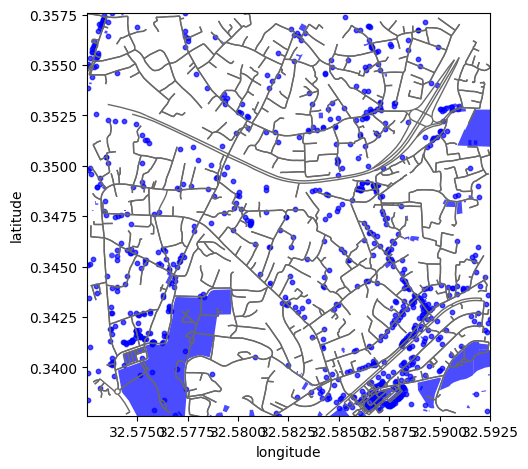

In [17]:
fig, ax = plt.subplots()

# Plot the footprint
area.plot(ax=ax, facecolor="white")

# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor="dimgray")

ax.set_xlim([west, east])
ax.set_ylim([south, north])
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

# Plot all POIs
pois.plot(ax=ax, color="blue", alpha=0.7, markersize=10)
plt.tight_layout()

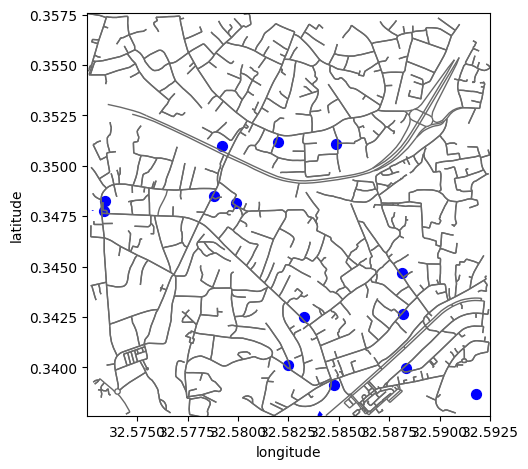

In [18]:
# Plot a subset of the POIs (e.g., tourist places)
# Create figure
fig, ax = plt.subplots()

# Plot the footprint
area.plot(ax=ax, facecolor="white")

# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor="dimgray")

ax.set_xlim([west, east])
ax.set_ylim([south, north])
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

# Plot tourist places
tourist_places = pois[pois.tourism.notnull()]
tourist_places.plot(ax=ax, color="blue", alpha=1, markersize=50)
plt.tight_layout()

We have the POI information on all tourist places structured in a
geodataframe. To work with them in a machine learning algorithm, it will
be easier to convert them to a pandas DataFrame.

In [7]:
import pandas as pd

In [20]:
pois_df = pd.DataFrame(pois)
pois_df['latitude'] = pois_df.apply(lambda row: row.geometry.centroid.y, axis=1)
pois_df['longitude'] = pois_df.apply(lambda row: row.geometry.centroid.x, axis=1)

tourist_places_df = pois_df[pois_df.tourism.notnull()]
print(len(tourist_places_df))
tourist_places_df

16


addr:housenumber           addr:street  \
element_type osmid                                               
node         3032234586              NaN                   NaN   
             4119308804              NaN                   NaN   
             4942954054              NaN                   NaN   
             5678162422              NaN                   NaN   
             7743212629              NaN                   NaN   
             8445011017              NaN      Kisingiri Street   
             8456545033              NaN          Mawanda Road   
             8456545129              NaN          Mawanda Road   
             8481722617              NaN                   NaN   
             8498971118              NaN                   NaN   
             8597526517              NaN                   NaN   
             8686698118              NaN          Oketcho Road   
             8686698119              NaN           Kasubi Road   
             8778105111          8HQJ+XW  New Mulago Gate Road   
way          437577068           Plot 72            Kiira Road   
             649469461               NaN                   NaN   

                                    amenity cuisine  \
element_type osmid                                    
node         3032234586                 NaN     NaN   
             4119308804  mobile_money_agent     NaN   
             4942954054                 NaN     NaN   
             5678162422                 NaN     NaN   
             7743212629                 NaN     NaN   
             8445011017                 NaN     NaN   
             8456545033                 NaN     NaN   
             8456545129                 NaN     NaN   
             8481722617                 NaN     NaN   
             8498971118                 NaN     NaN   
             8597526517                 NaN     NaN   
             8686698118                 NaN     NaN   
             8686698119                 NaN     NaN   
             8778105111                 NaN     NaN   
way          437577068                  NaN     NaN   
             649469461                  NaN     NaN   

                                              name            phone  \
element_type osmid                                                    
node         3032234586                    Fat Cat  +256 771 393892   
             4119308804                Green apple              NaN   
             4942954054                Okrut Close              NaN   
             5678162422          Tagore Apartments              NaN   
             7743212629                        NaN              NaN   
             8445011017               Prisma Hotel       0414371122   
             8456545033          Silverline Condos              NaN   
             8456545129            Kida Guesthouse              NaN   
             8481722617           Koda Guest House              NaN   
             8498971118         Mulago Guest House              NaN   
             8597526517           Papa Guest house              NaN   
             8686698118          Silent Corner inn              NaN   
             8686698119           Kerona Dam Hotel              NaN   
             8778105111                 Nyumba 591    +256792172017   
way          437577068   Hilton Garden Inn Kampala  +256 31 3800800   
             649469461    Ku spot inn accomodation              NaN   

                                                                   website  \
element_type osmid                                                           
node         3032234586                      http://www.fatcatkampala.com/   
             4119308804                                                NaN   
             4942954054                                                NaN   
             5678162422                                                NaN   
             7743212629                                                NaN   
             844501

In [21]:
poi_counts = {}

poi_types =["amenity", "historic", "leisure", "shop", "tourism", "religion", "memorial"]

for tag in poi_types:
  if tag in pois_df.columns:
    poi_counts[tag] = pois_df[tag].notnull().sum()
  else:
    poi_counts[tag] = 0

poi_counts_df = pd.DataFrame(list(poi_counts.items()), columns=['POI Type', 'Count'])



poi_counts_df

,POI Type,Count
0,amenity,729
1,historic,0
2,leisure,20
3,shop,163
4,tourism,16
5,religion,7
6,memorial,0


## Assessing the Available OpenStreetMap Features

<span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_datasets/includes/assessing-osm.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_datasets/includes/assessing-osm.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

In the course assessment you will be given the task of constructing a
prediction system for various indicators at a given location. We expect
that knowledge of the local region around the property should be helpful
in making those predictions. To evaluate this we will now look at
[OpenStreetMap](https://www.openstreetmap.org) as a data source.

In this section, you should follow the methodology used in the above
example to extract summary OSM information that can be useful in making
predictions about an area. Use code from the example to construct a
function that summarises the number of various points of interest in a
target area. You should write reusable code that allows you to explore
the characteristics of different points of interest.

In [1]:
def count_pois_near_coordinates(latitude: float, longitude: float, tags: dict, distance_km: float = 1.0) -> dict:
    """
    Count Points of Interest (POIs) near a given pair of coordinates within a specified distance.
    Args:
        latitude (float): Latitude of the location.
        longitude (float): Longitude of the location.
        tags (dict): A dictionary of OSM tags to filter the POIs (e.g., {'amenity': True, 'tourism': True}).
        distance_km (float): The distance around the location in kilometers. Default is 1 km.
    Returns:
        dict: A dictionary where keys are the OSM tags and values are the counts of POIs for each tag.
    """
    
    distance = distance_km / 111
    north = latitude + distance
    south = latitude - distance
    west = longitude - distance
    east = longitude + distance

    pois = ox.geometries_from_bbox(north, south, east, west, tags)
    pois_df = pd.DataFrame(pois)
    
    poi_counts = {}
    for tag, value in tags.items():
        if tag in pois_df.columns:
            if value is True:
                # count all POIs for this tag
                poi_counts[tag] = pois_df[tag].notnull().sum()
            elif isinstance(value, list):
                # count POIs that match one of the list values
                poi_counts[tag] = pois_df[tag].isin(value).sum()
            else:
                # raise an error
                raise ValueError(f"Unexpected value: tags[{tag}] = {value}")
        else:
            poi_counts[tag] = 0
    
    return poi_counts

Now that you have written reusable code, choose the tags you want to
query. This should be different from the tags used in the example. You
can also search for specific tags like this:
`"amenity": ["university", ...`.

In [2]:
tags = {
    "amenity": True,
    "historic": True,
    "leisure": True,
    "shop": True,
    "sport": ["tennis", "soccer", "squash", "multi", "bowls"],
    "tourism": True,
    "healthcare": True,
}

Here there are 13 UK locations.

In [3]:
locations_dict = {
    "Cambridge": (52.2054, 0.1132),
    "Oxford": (51.7570, -1.2545),
    "Euston Square": (51.5246, -0.1340),
    "Temple": (51.5115, -0.1160),
    "Kensington": (51.4988, -0.1749),
    "Barnsley": (53.5526, -1.4797),
    "Mansfield": (53.1472, -1.1987),
    "Wakefield": (53.6848, -1.5039),
    "Sunderland": (54.9069, -1.3838),
    "Rotherham": (53.4300, -1.3568),
    "Doncaster": (53.5228, -1.1288),
    "Chesterfield": (53.2350, -1.4210),
    "Huddersfield": (53.6450, -1.7794)
    }

### Exercise 1

Use your code to query the OSM feature counts for each of them, and
combine them into one dataframe.

### Exercise 1 Answer

Write your answer to Exercise 1 here

In [165]:
osm_feature_counts = {header: [] for header in ["location"] + list(tags.keys())}

for location, coords in locations_dict.items():

    latitude, longitude = coords[0], coords[1]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        poi_counts = count_pois_near_coordinates(latitude, longitude, tags)

    osm_feature_counts["location"].append(location)
    for tag, poi_count in poi_counts.items():
        osm_feature_counts[tag].append(poi_count)
    
    print(f"Location {location} has been processed.")

osm_feature_counts_df = pd.DataFrame(osm_feature_counts)

Location Cambridge has been processed.
Location Oxford has been processed.
Location Euston Square has been processed.
Location Temple has been processed.
Location Kensington has been processed.
Location Barnsley has been processed.
Location Mansfield has been processed.
Location Wakefield has been processed.
Location Sunderland has been processed.
Location Rotherham has been processed.
Location Doncaster has been processed.
Location Chesterfield has been processed.
Location Huddersfield has been processed.


In [166]:
osm_feature_counts_df

,location,amenity,historic,leisure,shop,sport,tourism,healthcare
0,Cambridge,1137,27,200,271,25,82,9
1,Oxford,1158,73,242,325,22,120,13
2,Euston Square,2141,109,121,591,8,171,65
3,Temple,1881,112,97,516,6,172,27
4,Kensington,1073,61,118,307,10,114,26
5,Barnsley,365,4,54,314,7,12,17
6,Mansfield,368,9,51,310,18,12,18
7,Wakefield,445,2,60,382,18,11,20
8,Sunderland,775,7,39,258,5,27,13
9,Rotherham,238,1,37,173,4,3,16


### Exercise 2

Use k-means clustering or another clustering method to try to find
clusters of similar areas, based on nearby OSM features.

### Exercise 2 Answer

Write your answer to Exercise 2 here

In [48]:
%pip install scikit-learn


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [206]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

In [253]:
def kmeans(data, n_clusters, normalise):

    locations = data['location']
    data = data.drop(columns=['location'])

    if normalise:
        # scaler = StandardScaler()
        scaler = MinMaxScaler()
        scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    else:
        scaled_data = data
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(scaled_data)
    clusters = kmeans.labels_

    clustered_locations = pd.DataFrame({"location": locations, 
                                        "latitude": [locations_dict[location][0] for location in locations_dict],
                                        "longitude": [locations_dict[location][1] for location in locations_dict],
                                        "cluster": clusters})
    clustered_locations = pd.concat([clustered_locations, data], axis=1)
    clustered_locations = clustered_locations.sort_values(by='cluster')

    return clustered_locations

In [254]:
clustered_locations = kmeans(data = osm_feature_counts_df.copy(), n_clusters = 3, normalise = False)
clustered_locations_with_normalisation = kmeans(data = osm_feature_counts_df.copy(), n_clusters = 3, normalise = True)

In [278]:
clustered_locations

,location,latitude,longitude,cluster,amenity,historic,leisure,shop,sport,tourism,healthcare
5,Barnsley,53.5526,-1.4797,0,365,4,54,314,7,12,17
6,Mansfield,53.1472,-1.1987,0,368,9,51,310,18,12,18
7,Wakefield,53.6848,-1.5039,0,445,2,60,382,18,11,20
9,Rotherham,53.4300,-1.3568,0,238,1,37,173,4,3,16
10,Doncaster,53.5228,-1.1288,0,273,3,20,220,3,15,4
11,Chesterfield,53.2350,-1.4210,0,346,1,29,271,3,13,10
12,Huddersfield,53.6450,-1.7794,0,382,8,22,290,5,11,6
2,Euston Square,51.5246,-0.1340,1,2141,109,121,591,8,171,65
3,Temple,51.5115,-0.1160,1,1881,112,97,516,6,172,27
0,Cambridge,52.2054,0.1132,2,1137,27,200,271,25,82,9


In [256]:
clustered_locations_with_normalisation

,location,latitude,longitude,cluster,amenity,historic,leisure,shop,sport,tourism,healthcare
6,Mansfield,53.1472,-1.1987,0,368,9,51,310,18,12,18
7,Wakefield,53.6848,-1.5039,0,445,2,60,382,18,11,20
0,Cambridge,52.2054,0.1132,1,1137,27,200,271,25,82,9
1,Oxford,51.7570,-1.2545,1,1158,73,242,325,22,120,13
2,Euston Square,51.5246,-0.1340,1,2141,109,121,591,8,171,65
3,Temple,51.5115,-0.1160,1,1881,112,97,516,6,172,27
4,Kensington,51.4988,-0.1749,1,1073,61,118,307,10,114,26
5,Barnsley,53.5526,-1.4797,2,365,4,54,314,7,12,17
8,Sunderland,54.9069,-1.3838,2,775,7,39,258,5,27,13
9,Rotherham,53.4300,-1.3568,2,238,1,37,173,4,3,16


### Exercise 3

Investigate the locations yourself, and assign them categories based on
your interpretation. Visualise and compare your manual assignments
against your clustering results.

### Exercise 3 Answer

Write your answer to Exercise 3 here

In [257]:
osm_feature_counts_df

,location,amenity,historic,leisure,shop,sport,tourism,healthcare
0,Cambridge,1137,27,200,271,25,82,9
1,Oxford,1158,73,242,325,22,120,13
2,Euston Square,2141,109,121,591,8,171,65
3,Temple,1881,112,97,516,6,172,27
4,Kensington,1073,61,118,307,10,114,26
5,Barnsley,365,4,54,314,7,12,17
6,Mansfield,368,9,51,310,18,12,18
7,Wakefield,445,2,60,382,18,11,20
8,Sunderland,775,7,39,258,5,27,13
9,Rotherham,238,1,37,173,4,3,16


In [268]:
manual_clusters = [2, 2, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0]

clustered_locations_manually = pd.DataFrame({"location": locations_dict.keys(),
                                             "latitude": [locations_dict[location][0] for location in locations_dict],
                                             "longitude": [locations_dict[location][1] for location in locations_dict],
                                             "cluster": manual_clusters})

In [259]:
def plot_clusters(clustered_locations):
    cluster_colors = {0: 'red', 1: 'green', 2: 'blue'}

    plt.figure(figsize = (10, 10))
    for cluster, color in cluster_colors.items():
        cluster_data = clustered_locations[clustered_locations['cluster'] == cluster]
        plt.scatter(
            cluster_data['longitude'], 
            cluster_data['latitude'], 
            label=f'Cluster {cluster}', 
            color=color, 
            s=100, 
            alpha=0.6, 
            edgecolor='k'
        )
        for _, row in cluster_data.iterrows():
            plt.text(row['longitude'] + 0.05, row['latitude'] + 0.05, row['location'], fontsize=9)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.axis('equal')
    plt.legend(title='Clusters')
    plt.title('Map of cities by cluster')
    plt.grid(True)
    plt.show()

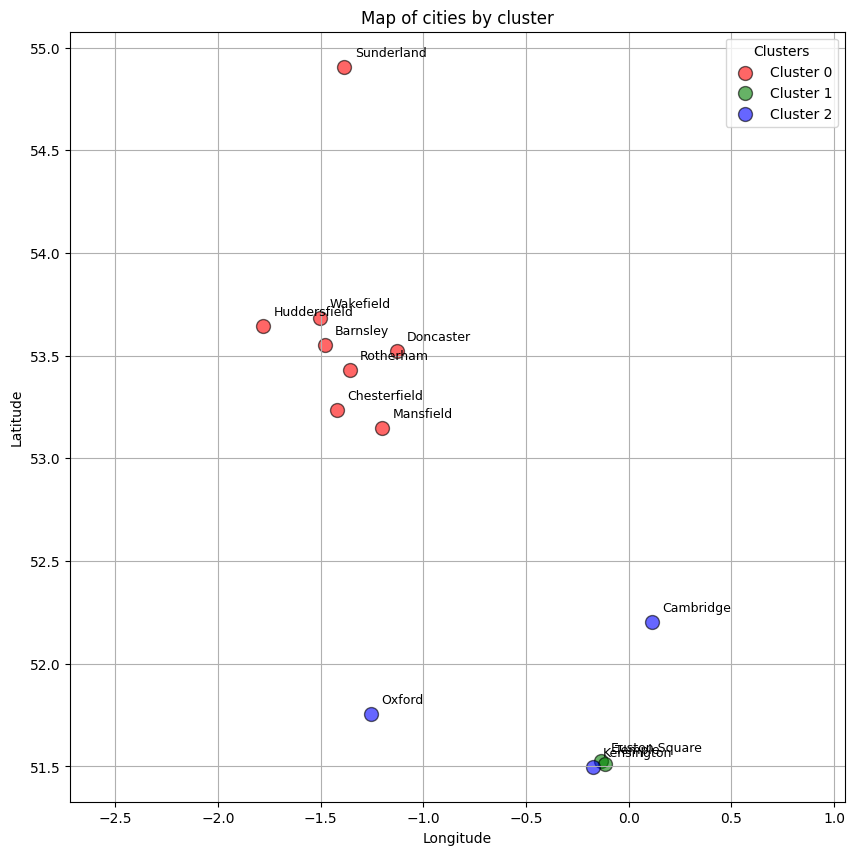

In [263]:
plot_clusters(clustered_locations_manually)

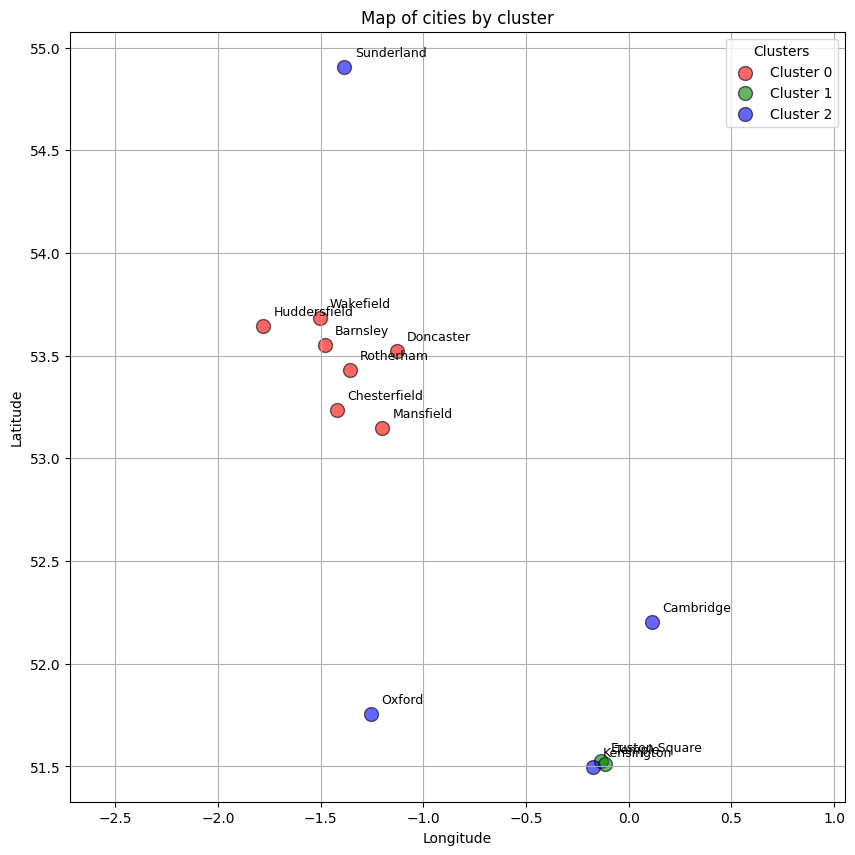

In [264]:
plot_clusters(clustered_locations)

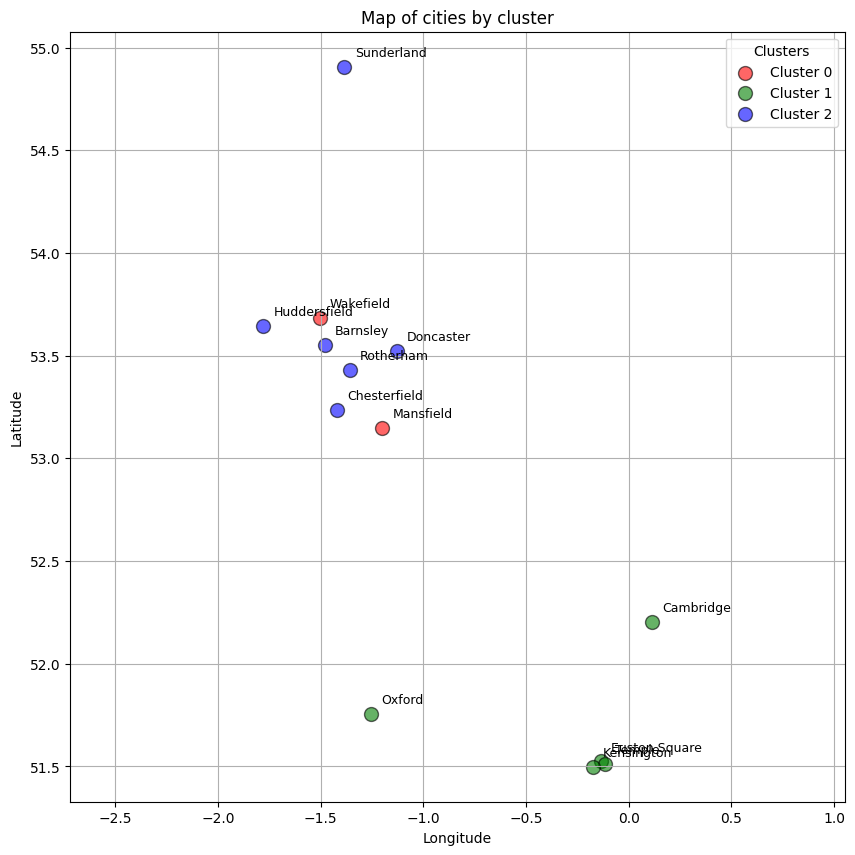

In [265]:
plot_clusters(clustered_locations_with_normalisation)

### Exercise 4

Normalise your dataframe and compute a distance matrix for the
locations. Visualise it, and compare the outcode with your previous
clustering results.

### Exercise 4 Answer

Write your answer to Exercise 4 here

In [300]:
locations_df = clustered_locations.copy()
locations_df = locations_df.drop(columns=['cluster'])
locations_df = locations_df.sort_index()

In [301]:
locations_df

,location,latitude,longitude,amenity,historic,leisure,shop,sport,tourism,healthcare
0,Cambridge,52.2054,0.1132,1137,27,200,271,25,82,9
1,Oxford,51.7570,-1.2545,1158,73,242,325,22,120,13
2,Euston Square,51.5246,-0.1340,2141,109,121,591,8,171,65
3,Temple,51.5115,-0.1160,1881,112,97,516,6,172,27
4,Kensington,51.4988,-0.1749,1073,61,118,307,10,114,26
5,Barnsley,53.5526,-1.4797,365,4,54,314,7,12,17
6,Mansfield,53.1472,-1.1987,368,9,51,310,18,12,18
7,Wakefield,53.6848,-1.5039,445,2,60,382,18,11,20
8,Sunderland,54.9069,-1.3838,775,7,39,258,5,27,13
9,Rotherham,53.4300,-1.3568,238,1,37,173,4,3,16


In [287]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [288]:
import numpy as np

In [302]:
def distance(lat1, lon1, lat2, lon2):
    lat_diff = abs(lat1 - lat2) * 111
    lon_diff = abs(lon1 - lon2) * 111
    return np.sqrt(lat_diff**2 + lon_diff**2)

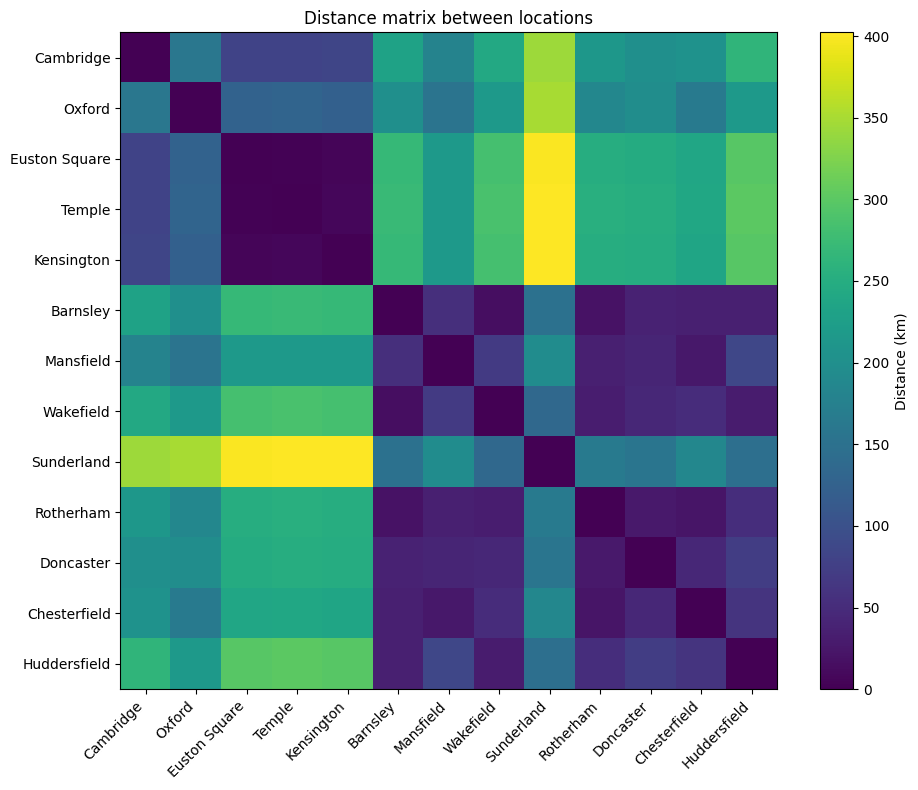

In [307]:
# Create an empty distance matrix
distance_matrix = np.zeros((len(locations_df), len(locations_df)))

# Calculate pairwise distances
for i in range(len(locations_df)):
    for j in range(len(locations_df)):
        if i != j:
            distance_matrix[i, j] = distance(
                locations_df.loc[i, 'latitude'], 
                locations_df.loc[i, 'longitude'],
                locations_df.loc[j, 'latitude'], 
                locations_df.loc[j, 'longitude']
            )

# Convert the distance matrix into a DataFrame
distance_matrix_df = pd.DataFrame(distance_matrix, columns=locations_df['location'], index=locations_df['location'])

# Plotting the distance matrix as a heatmap using Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(distance_matrix_df, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Distance (km)')

# Displaying the plot
plt.title("Distance matrix between locations")
plt.xticks(np.arange(len(locations_df)), locations_df['location'], rotation=45, ha='right')
plt.yticks(np.arange(len(locations_df)), locations_df['location'])
plt.tight_layout()
plt.show()


In [315]:
osm_feature_counts_df

,location,amenity,historic,leisure,shop,sport,tourism,healthcare
0,Cambridge,1137,27,200,271,25,82,9
1,Oxford,1158,73,242,325,22,120,13
2,Euston Square,2141,109,121,591,8,171,65
3,Temple,1881,112,97,516,6,172,27
4,Kensington,1073,61,118,307,10,114,26
5,Barnsley,365,4,54,314,7,12,17
6,Mansfield,368,9,51,310,18,12,18
7,Wakefield,445,2,60,382,18,11,20
8,Sunderland,775,7,39,258,5,27,13
9,Rotherham,238,1,37,173,4,3,16


In [316]:

data = osm_feature_counts_df.copy()
locations = data['location']
data = data.drop(columns=['location'])

scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

locations_df = pd.DataFrame({"location": locations})
normalized_osm_feature_counts_df = pd.concat([locations_df, scaled_data], axis=1)

In [317]:
normalized_osm_feature_counts_df

,location,amenity,historic,leisure,shop,sport,tourism,healthcare
0,Cambridge,0.472412,0.234234,0.810811,0.234450,1.000000,0.467456,0.081967
1,Oxford,0.483447,0.648649,1.000000,0.363636,0.863636,0.692308,0.147541
2,Euston Square,1.000000,0.972973,0.454955,1.000000,0.227273,0.994083,1.000000
3,Temple,0.863374,1.000000,0.346847,0.820574,0.136364,1.000000,0.377049
4,Kensington,0.438781,0.540541,0.441441,0.320574,0.318182,0.656805,0.360656
5,Barnsley,0.066737,0.027027,0.153153,0.337321,0.181818,0.053254,0.213115
6,Mansfield,0.068313,0.072072,0.139640,0.327751,0.681818,0.053254,0.229508
7,Wakefield,0.108776,0.009009,0.180180,0.500000,0.681818,0.047337,0.262295
8,Sunderland,0.282186,0.054054,0.085586,0.203349,0.090909,0.142012,0.147541
9,Rotherham,0.000000,0.000000,0.076577,0.000000,0.045455,0.000000,0.196721


### Exercise 5

Which features you included were correlated among each other?
Investigate and plot a feature correlation matrix. What do these results
say about your feature selection?

### Exercise 5 Answer

Write your answer to Exercise 5 here

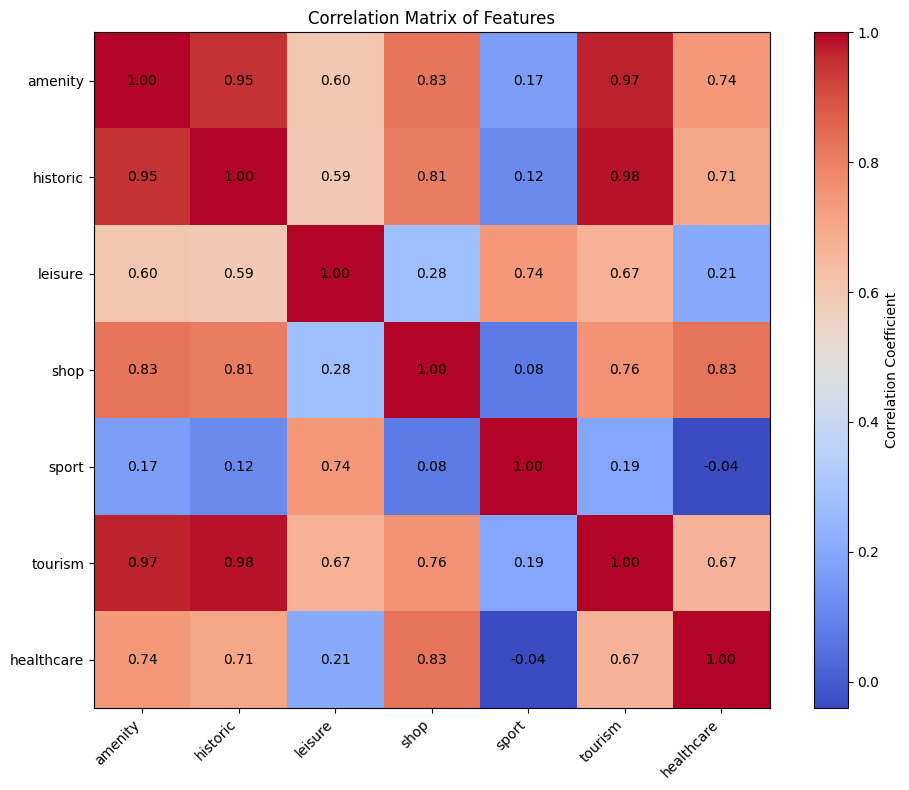

In [322]:
df = normalized_osm_feature_counts_df.copy()
df = df.drop(columns=['location'])

correlation_matrix = df.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.title("Correlation Matrix of Features")

# Add x and y ticks with column names
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

# Add correlation values on top of the heatmap
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha="center", va="center", color="black")

plt.tight_layout()
plt.show()

## Joining Spatial Data

<span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_access/includes/spatial-join.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_access/includes/spatial-join.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

### Matching OpenStreetMap and House Prices data

In this exercise you will download the geographies of houses from
OpenStreetMap and map them to visualise the records you see in the house
price dataset. This is a data linking and validation exercise.

The latitude and longitude of Cambridge are as follows:

In [75]:
place_name = "Cambridge"
latitude = 52.1951
longitude = 0.1313

We want to execute an SQL query on your database to select all houses in
a 1km x 1km region around the centre of Cambridge that have been part of
housing transactions since 2020.

This operation can take a very long time. This is because the table is
not indexed on coordinate data, and therefore the query has to check
tens of millions of rows. This can be fixed by constructing an index on
the `latitude` and `longitude` values, using `BTREE` to make a joint
index. *Note that indexing can take a long time.* Consider also indexing
your table by other variables you might find useful later.

### Exercise 6

Index the table on the coordinate data using a `BTREE` and index other
columns you might find useful.

### Exercise 6 Answer

Write your answer to Exercise 6 here

In [ ]:
%pip install pyyaml
%pip install ipython-sql
%pip install PyMySQL
%pip install pymysql
%load_ext sql

In [94]:
import yaml
import pymysql

In [ ]:
%pip uninstall --yes fynesse
%pip install git+https://github.com/sdenyskov/sd995_ads_2024.git

In [95]:
import fynesse

In [96]:
with open("credentials.yaml") as file:
  credentials = yaml.safe_load(file)
username = credentials["username"]
password = credentials["password"]
url = credentials["url"]
port = credentials["port"]

In [324]:
conn = fynesse.access.create_connection(user=username, password=password, host=url, database='ads_2024')
cursor = conn.cursor()

Connection established!


In [112]:
cursor.execute("CREATE INDEX idx_lat_lon_btree ON `prices_coordinates_data` (latitude, longitude)")
conn.commit()

In [328]:
cursor.execute("SHOW INDEXES FROM `prices_coordinates_data`")
results = cursor.fetchall()
for result in results:
    print(result)

('prices_coordinates_data', 0, 'PRIMARY', 1, 'db_id', 'A', 5319673, None, None, '', 'BTREE', '', '', 'NO')
('prices_coordinates_data', 1, 'idx_lat_lon_btree', 1, 'latitude', 'A', 2659836, None, None, '', 'BTREE', '', '', 'NO')
('prices_coordinates_data', 1, 'idx_lat_lon_btree', 2, 'longitude', 'A', 2659836, None, None, '', 'BTREE', '', '', 'NO')


In [117]:
cursor.execute("SELECT column_name FROM information_schema.columns WHERE table_name = 'prices_coordinates_data'")
results = cursor.fetchall()
for result in results:
    print(result[0])

price
date_of_transfer
postcode
property_type
new_build_flag
tenure_type
locality
town_city
district
county
country
latitude
longitude
db_id


In [325]:
cursor.execute("SELECT MIN(date_of_transfer) AS min_value, MAX(date_of_transfer) AS max_value FROM `prices_coordinates_data`")
results = cursor.fetchall()
print(results)

((datetime.date(2020, 1, 1), datetime.date(2024, 9, 30)),)


### Exercise 7

Write an SQL query on your database to select all houses in a 1km x 1km
region around the centre of Cambridge that have been part of housing
transactions since 2020.

### Exercise 7 Answer

Write your answer to Exercise 7 here

In [127]:
for year in range(2020, 2023):
    fynesse.access.housing_upload_join_data(conn, year)
    print(f"Data for year {year} has been successfully uploaded")

Selecting data for year: 2020
Storing data for year: 2020
Data stored for year: 2020
Data for year 2020 has been successfully uploaded
Selecting data for year: 2021
Storing data for year: 2021
Data stored for year: 2021
Data for year 2021 has been successfully uploaded
Selecting data for year: 2022
Storing data for year: 2022
Data stored for year: 2022
Data for year 2022 has been successfully uploaded


### Exercise 8

Get information about all the buildings in that area from OpenStreetMaps
(`'building': True`). You will need their address information
(`addr:housenumber`, `addr:street`, `addr:postcode`, …) and geometry
polygon (`geometries_from_bbox`). Construct a dataframe that lists all
OSM buildings in the area that have a full address, along with their
area (in square meters). Plot a map of the area, using color to mark the
buildings with addresses and the ones without.

### Exercise 8 Answer

Write your answer to Exercise 8 here

In [ ]:
# Use this box for any code you need



### Exercise 9

Match the houses you found in the price paid dataset with the buildings
on OpenStreetMaps based on their addresses. Can this be applied to all
building types? Are there any PP transactions which you couldn’t match
to an OSM building, or any OSM buildings you coulnd’t match to a PP
transaction? If so, what could be the reason for this? Do you employ any
techniques to find non-exact matches? If yes, what matches would you
have missed without it? Are you encountering false positive matches? Use
this address matching to merge the two dataframes.

### Exercise 9 Answer

Write your answer to Exercise 9 here

In [ ]:
# Use this box for any code you need



### Exercise 10

Examine the relationship between the price and area of a property. -
What other variables do you need to account for? - Is the correlation as
strong as you would expect? - What factors could be impacting this?

Visualise the relationships you found.

### Exercise 10 Answer

Write your answer to Exercise 10 here

In [ ]:
# Use this box for any code you need



Demonstrate the reusability of your code by executing the same analysis
for Oxford.

In [ ]:
place_name = "Oxford"

latitude = 51.7520
longitude = -1.2577

### Exercise 11

Replicating the same analysis for Oxford. You do not need to answer all
the questions again, but you should show that your code works for this
new input without the need to modify it. You should use the Fynesse
library for this. Finish by plotting a map of the area and the
correlation you find.

### Exercise 11 Answer

Write your answer to Exercise 11 here

In [ ]:
# Use this box for any code you need



## Conclusions

You should find some of the code you wrote above useful in your final
assessment. Make sure you wrote the code to be reusable and efficient,
and do include it in your Fynesse library. The functions you are
particularly likely to reuse are the OSM feature search, and map
visualisation functions.

### Exercise 12

Add relevant code to your Fynesse library. Demonstrate this was
successful by installing your library below and calling at least two
example functions.

### Exercise 12 Answer

Write your answer to Exercise 12 here

In [ ]:
# Use this box for any code you need



## Thanks!

For more information on these subjects and more you might want to check
the following resources.

-   book: [The Atomic
    Human](https://www.penguin.co.uk/books/455130/the-atomic-human-by-lawrence-neil-d/9780241625248)
-   twitter: [@lawrennd](https://twitter.com/lawrennd)
-   podcast: [The Talking Machines](http://thetalkingmachines.com)
-   newspaper: [Guardian Profile
    Page](http://www.theguardian.com/profile/neil-lawrence)
-   blog:
    [http://inverseprobability.com](http://inverseprobability.com/blog.html)

## References